In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from numpy import loadtxt
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose, Flatten, Reshape, Add, Concatenate, Dropout
import keras.backend as K
from keras.models import model_from_json
from keras import regularizers
import keras 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

import kerastuner as kt
from kerastuner import HyperModel
from kerastuner import Hyperband, RandomSearch

import os
import shutil

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


# Load data

In [2]:
train_name = 'train6'
test_name = 'test3'
size = 4096
method = 'Autoencoder' #'Fourier' or 'Autoencoder'

# Load true scaled time traces
train_true = pd.read_pickle(train_name + '_data_cut.pkl').T
test_true = pd.read_pickle(test_name + '_data_cut.pkl').T

# Save t-axis
train_t = pd.read_pickle(train_name + '_t_cut.pkl').T
test_t = pd.read_pickle(test_name + '_t_cut.pkl').T

# Get column names of selected samples
train_sample_ids = list(train_true.T)
train_name_dict = {}
for i in range(len(train_sample_ids)):
    train_name_dict[i] = train_sample_ids[i]
    
test_sample_ids = list(test_true.T)
test_name_dict = {}
for i in range(len(test_sample_ids)):
    test_name_dict[i] = test_sample_ids[i]

# Load parameter sets and select desired columns
train_parameters = pd.read_pickle(train_name + '_parameters.pkl')[train_sample_ids].T
test_parameters = pd.read_pickle(test_name + '_parameters.pkl')[test_sample_ids].T

# Load features to be learned
if method == 'Fourier':
    #fourier coefficients
    train_latent = pd.read_pickle(train_name + '_32Fourier_coefficients.pkl')
    test_latent = pd.read_pickle(test_name + '_32Fourier_coefficients.pkl')
if method == 'Autoencoder':
    #latent space variables
    train_latent = pd.read_pickle(train_name + '_AE_latentSpace.pkl').rename(index=train_name_dict)
    test_latent = pd.read_pickle(test_name + '_AE_latentSpace.pkl').rename(index=test_name_dict)
    
# add frequency, max_values and min_values to the features to be learned
latent_shape = train_latent.shape[1] + 3
train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]] = pd.read_pickle(train_name + '_scaled_indiv.pkl').T[[size,size+1,size+2]]
test_latent[[latent_shape-3, latent_shape-2, latent_shape-1]] = pd.read_pickle(test_name + '_scaled_indiv.pkl').T[[size,size+1,size+2]]


# Preprocessing

## Parameter scaling

In [3]:
bound_cah_dend = [5, 20]
bound_cal_soma = [10, 40]
bound_h_dend = [12.5, 50]
bound_k_axon = [10, 40] 
bound_k_soma = [7.5, 30]
bound_kca_dend = [17.5, 70]
bound_kdr_soma = [15, 60]
bound_leak = [6.5e-3, 26e-3]
bound_na_axon = [100, 400] 
bound_na_s_soma = [15, 60]

lower_bounds = [bound_cah_dend[0], bound_cal_soma[0], bound_h_dend[0], bound_k_axon[0], bound_k_soma[0],
               bound_kca_dend[0], bound_kdr_soma[0], bound_leak[0], bound_na_axon[0], bound_na_s_soma[0]]
upper_bounds = [bound_cah_dend[1], bound_cal_soma[1], bound_h_dend[1], bound_k_axon[1], bound_k_soma[1],
               bound_kca_dend[1], bound_kdr_soma[1], bound_leak[1], bound_na_axon[1], bound_na_s_soma[1]]

train_parameters_scaled = (train_parameters - lower_bounds) / ([upper_bounds[i] - lower_bounds[i] for i in range(len(lower_bounds))])
test_parameters_scaled = (test_parameters - lower_bounds) / ([upper_bounds[i] - lower_bounds[i] for i in range(len(lower_bounds))])

## Latent space variable scaling

In [4]:
if method == 'Fourier':
    train_latent_scaled = (train_latent - train_latent.min()) / (train_latent.max() - train_latent.min())
    test_latent_scaled = (test_latent - train_latent.min()) / (train_latent.max() - train_latent.min())

if method == 'Autoencoder':
    train_latent_scaled = train_latent.copy()
    test_latent_scaled = test_latent.copy()
    train_latent_scaled[[latent_shape-3, latent_shape-2, latent_shape-1]] = (train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]] - 
                                                                             train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].min()) / (train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].max() - 
                                                                                                                                                      train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].min())
    test_latent_scaled[[latent_shape-3, latent_shape-2, latent_shape-1]] = (test_latent[[latent_shape-3, latent_shape-2, latent_shape-1]] - 
                                                                             train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].min()) / (train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].max() - 
                                                                                                                                                      train_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].min())

# Create trial NN

In [5]:
input_dim = train_parameters_scaled.shape[1]
output_dim = train_latent_scaled.shape[1]

In [6]:
if method == 'Fourier': 
    input_layer = Input(shape=(input_dim,), name = "INPUT")
    x = Dense(16, activation = 'swish')(input_layer)
    x = Dense(32, activation = 'swish')(x)
    x = Dense(64, activation = 'swish')(x)
    x = Dense(32, activation = 'swish')(x)
    x = Dense(16, activation = 'swish')(x)
    x = Concatenate(axis = 1)([x, input_layer])
    output_layer = Dense(output_dim, activation='sigmoid')(x)
    
if method == 'Autoencoder':
    input_layer = Input(shape=(input_dim,), name = "INPUT")
    x = Dense(16, kernel_regularizer=regularizers.l1(0.01), activation = 'swish')(input_layer)
    x = Dense(32, kernel_regularizer=regularizers.l1(0.01), activation = 'swish')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=regularizers.l1(0.01), activation = 'swish')(x)
    x = Dense(128, kernel_regularizer=regularizers.l1(0.01), activation = 'swish')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=regularizers.l1(0.01), activation = 'swish')(x)
    x = Concatenate(axis = 1)([x, input_layer])
    output_layer = Dense(output_dim, activation='sigmoid')(x)

# Define loss functions

In [7]:
# Load decoder
json_file = open(train_name + '_decoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
decoder = model_from_json(loaded_model_json)
decoder.load_weights(train_name + "_decoder.h5")

t_old = np.linspace(0, 1, size)

def resample_time(custom_func_input):
    if custom_func_input[-1,0] > 1 and custom_func_input[-1,0] < 12:
        t_end = 6 / custom_func_input[-1,0]
        new_size = t_end * size
        new_size = K.cast(K.round(new_size), 'int32')
        image = K.expand_dims(K.expand_dims(custom_func_input[:-1,:], axis = 0), axis = 2)
        #resized_image = K.resize_images(image, factor, 1, data_format='channels_last')
        resized_image = tf.image.resize(image, [new_size, 1])
        custom_func_output = resized_image[0,:int(size/2),:,0]
        
        return custom_func_output
    
    else:
        return K.constant(1, shape = (int(size/2), 1))
    
def postProcessing_Autoencoder(latent_space_variables):
    time_series = decoder(latent_space_variables[:,:latent_shape-3])

    freqs = latent_space_variables[:,latent_shape - 3] * (train_latent[latent_shape - 3].max(axis = 0) - 
                                                          train_latent[latent_shape - 3].min(axis = 0)) + train_latent[latent_shape - 3].min(axis = 0)
    freqs_mat = K.repeat(K.expand_dims(freqs, axis = 1), size)
    max_vals = latent_space_variables[:,latent_shape - 2] * (train_latent[latent_shape - 2].max(axis = 0) - 
                                                          train_latent[latent_shape - 2].min(axis = 0)) + train_latent[latent_shape - 2].min(axis = 0)
    max_vals_mat = K.repeat(K.expand_dims(max_vals, axis = 1), size)
    min_vals = latent_space_variables[:,latent_shape - 1] * (train_latent[latent_shape - 1].max(axis = 0) - 
                                                          train_latent[latent_shape - 1].min(axis = 0)) + train_latent[latent_shape - 1].min(axis = 0)
    min_vals_mat = K.repeat(K.expand_dims(min_vals, axis = 1), size)
    print(max_vals)
    print(max_vals_mat)
    print(min_vals)
    print(min_vals_mat)
    print()
    
    time_series_amplitudeScaledBack = time_series * (max_vals_mat - min_vals_mat) + min_vals_mat

    custom_func_input = K.concatenate([time_series_amplitudeScaledBack, K.expand_dims(K.expand_dims(freqs, axis = 1), axis = 1)], axis = 1)
    time_series_scaledBack = tf.map_fn(lambda x: resample_time(x), custom_func_input)
    
    return time_series_amplitudeScaledBack

def loss_in_Vt_space(y_true, y_pred): 
    y_true_Vt = postProcessing_Autoencoder(y_true)
    y_pred_Vt = postProcessing_Autoencoder(y_pred)
    
    loss = K.mean(K.square(y_pred_Vt - y_true_Vt))
    
    return loss

def weighted_mse_latent_space(y_true, y_pred):
 
    # calculating squared difference between target and predicted values 
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    extra_weight = 0
    if method == 'Fourier':
        extra_weight = 10
    if method == 'Autoencoder':
        extra_weigth = 10
    weights = [1/(latent_shape + extra_weight * 3)] * (latent_shape - 3) + [(extra_weight + 1)/(latent_shape + extra_weight * 3)] * 3
    loss = loss * weights
    loss = K.sum(loss, axis=1)        # (batch_size,)
    
    return loss

In [8]:
# aap = K.expand_dims(K.constant(train_latent_scaled.iloc[0].values), axis = 0)
# backaap = postProcessing_Autoencoder(aap).numpy()
# #print(backaap)
# plt.figure()
# plt.plot(backaap[0,:,0])
# plt.plot(train_true.iloc[0].values)
# plt.plot()

In [9]:
NN = Model(input_layer, output_layer)
NN.compile(optimizer='adam', loss=weighted_mse_latent_space) #, run_eagerly = True)

# Hyperparameter optimization

In [10]:
# def build_model(hp):
#     my_activation = hp.Choice('dense_activation', values = ['swish', 'relu', 'sigmoid'], default = 'swish')
#     my_activation_output = hp.Choice('dense_out_activation', values = ['swish', 'relu', 'sigmoid'], default = 'swish')
#     my_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
#     input_layer = Input(shape=(input_dim,))
#     x = input_layer

#     for i in range(hp.Int('num_layers', 1, 8)):
#         my_units = hp.Choice('dense_units_' + str(i), values = [16, 32, 64, 128])
#         my_dropout = hp.Float('dropout_factor' + str(i), min_value = 0.0, max_value = 0.8, step = 0.1)
#         my_regularizer_value = hp.Float('dense_regularizer', min_value = 0, max_value = 0.2, step = 0.05)
        
#         x = Dense(units=my_units, kernel_regularizer=regularizers.l1(my_regularizer_value), 
#                   activation=my_activation)(x)
#         x = Dropout(my_dropout)(x)

#     x = Concatenate(axis = 1)([x, input_layer])

#     output_layer = Dense(units=output_dim, 
#                         activation=my_activation_output)(x)

#     model = keras.Model(input_layer, output_layer)

#     model.compile(optimizer=keras.optimizers.Adam(my_learning_rate), 
#               loss=weighted_mse_latent_space, metrics=['accuracy'])

#     return model

In [11]:
# location = os.getcwd()
# directory = 'hyperband_results'
# path = os.path.join(location, directory)
# try: 
#     shutil.rmtree(path)
# except FileNotFoundError:
#     pass    

# tuner_hp = Hyperband(build_model, 
#                      objective = 'accuracy',
#                      max_epochs = 20,  
#                      factor = 2, 
#                      directory = 'hyperband_results')

# early_stopping = EarlyStopping(monitor='val_loss', patience=15)
# tuner_hp.search(train_parameters_scaled, train_latent_scaled, epochs = 200, validation_split = 0.2, callbacks=[early_stopping])
# best_hypers = tuner_hp.get_best_hyperparameters(num_trials=1)[0]
# NN_temp = tuner_hp.get_best_models(num_models=1)[0]

In [12]:
# NN_temp.summary()

# Determine best number of epochs

In [13]:
# history_temp = NN_temp.fit(train_parameters_scaled, train_latent_scaled, epochs = 200, validation_split = 0.2, shuffle = True)
# val_acc_per_epoch = history_temp.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' %(best_epoch, ))

In [14]:
# NN = tuner_hp.hypermodel.build(best_hypers)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
history = NN.fit(train_parameters_scaled, train_latent_scaled, epochs = 1000, validation_split = 0.2, callbacks=[early_stopping])

Epoch 1/1000
13/13 [==============================] - 1s 43ms/step - loss: 17.8042 - val_loss: 16.0102
Epoch 2/1000
13/13 [==============================] - 0s 7ms/step - loss: 15.4624 - val_loss: 13.8021
Epoch 3/1000
13/13 [==============================] - 0s 7ms/step - loss: 13.2952 - val_loss: 11.7631
Epoch 4/1000
13/13 [==============================] - 0s 7ms/step - loss: 11.2982 - val_loss: 9.8972
Epoch 5/1000
13/13 [==============================] - 0s 7ms/step - loss: 9.4736 - val_loss: 8.1975
Epoch 6/1000
13/13 [==============================] - 0s 7ms/step - loss: 7.8171 - val_loss: 6.6705
Epoch 7/1000
13/13 [==============================] - 0s 7ms/step - loss: 6.3309 - val_loss: 5.3194
Epoch 8/1000
13/13 [==============================] - 0s 7ms/step - loss: 5.0221 - val_loss: 4.1347
Epoch 9/1000
13/13 [==============================] - 0s 6ms/step - loss: 3.8771 - val_loss: 3.1199
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 2.9050 - val_loss

In [15]:
# def plot_metric(history, metric):
#     train_metrics = history.history[metric]
#     val_metrics = history.history['val_'+metric]
#     epochs = range(1,len(train_metrics)+1)
#     plt.plot(epochs, train_metrics)
#     plt.plot(epochs, val_metrics)
#     plt.title("Training and Validation "+metric)
#     plt.xlabel("Epochs")
#     plt.ylabel("Metric")
#     plt.legend(["train_"+metric,"val_"+metric])
#     plt.show

# plot_metric(history, 'accuracy')

# Train with custom loss

In [16]:
# if method == 'Autoencoder':
#     my_loss = loss_in_Vt_space
#     NN.compile(optimizer='adam', loss=my_loss) #, run_eagerly = True)
#     early_stopping = EarlyStopping(monitor='loss', patience=15)
#     history = NN.fit(train_parameters_scaled, train_latent_scaled, validation_split = 0.2, epochs = 100, callbacks=[early_stopping])
#     plot_metric(history, 'loss')

# Evaluate results

In [17]:
train_error = NN.evaluate(train_parameters_scaled, train_latent_scaled)
test_error = NN.evaluate(test_parameters_scaled, test_latent_scaled)

# print('Train loss: %f, train accuracy: %f' %(train_error[0], train_error[1]))
# print('Test loss: %f, test accuracy: %f' %(test_error[0], test_error[1]))

4/4 [==============================] - 0s 2ms/step - loss: 0.0476


## Visualizing latent space fit

TRAINING SET


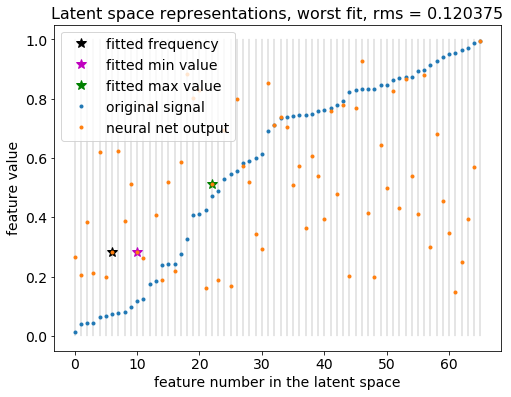

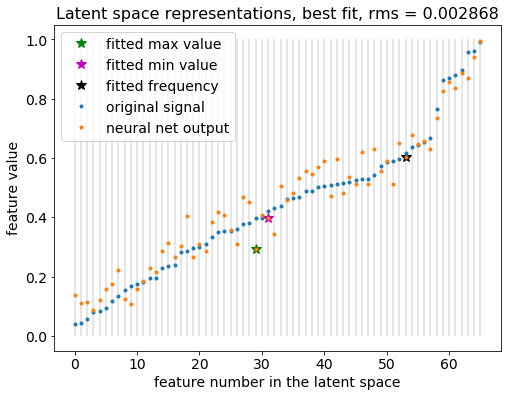

TEST SET


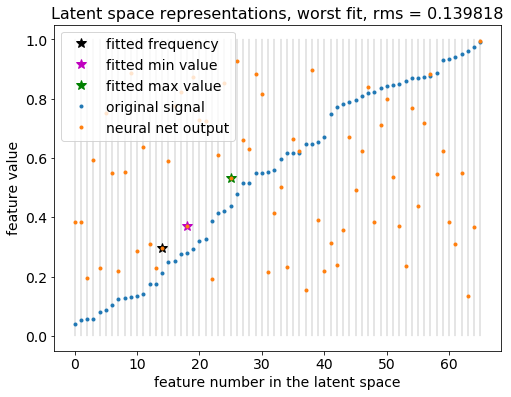

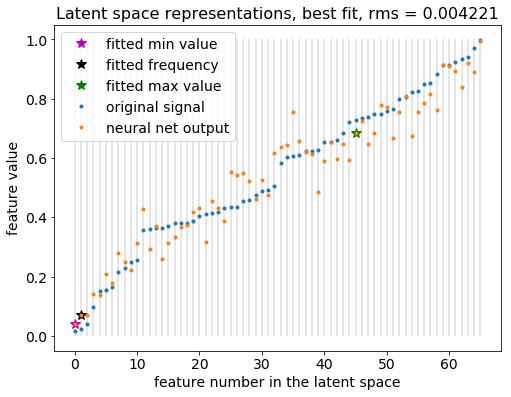

In [18]:
def plot_best_and_worst_fit(y_pred, y_true, height = 6, width = 8):
    plt.rcParams['figure.figsize'] = [width, height]
    
    rms = np.array(weighted_mse_latent_space(y_pred, y_true))
    
    max_loc = rms.argmax()
    min_loc = rms.argmin()
    
    order = np.argsort(y_true.iloc[max_loc]).values
    plt.figure()
    for i in order:
        plt.plot([i, i], [0, 1], 'k', linewidth=0.2)
    j = 0
    for i in order:
        if i == latent_shape - 3:
            plt.plot(j, [y_pred.iloc[max_loc].values[latent_shape - 3]], '*k', markersize = 10, label = 'fitted frequency')
        if i == latent_shape - 2:
            plt.plot(j, [y_pred.iloc[max_loc].values[latent_shape - 2]], '*g', markersize = 10, label = 'fitted max value')
        if i == latent_shape - 1:
            plt.plot(j, [y_pred.iloc[max_loc].values[latent_shape - 1]], '*m', markersize = 10, label = 'fitted min value')
        j += 1
    plt.plot([y_true.iloc[max_loc].values[i] for i in order], '.', label = 'original signal')
    plt.plot([y_pred.iloc[max_loc].values[i] for i in order], '.', label = 'neural net output')
    plt.legend(loc='upper left', fontsize=14)
    plt.title('Latent space representations, worst fit, rms = %f' %rms.max(), fontsize=16)
    #plt.xlim([0.1, 0.3])
    plt.xlabel('feature number in the latent space', fontsize=14)
    plt.ylabel('feature value', fontsize=14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show() 
    
    order = np.argsort(y_true.iloc[min_loc]).values
    plt.figure()
    for i in order:
        plt.plot([i, i], [0, 1], 'k', linewidth=0.2)
    j = 0
    for i in order:
        if i == latent_shape - 3:
            plt.plot(j, [y_pred.iloc[min_loc].values[latent_shape - 3]], '*k', markersize = 10, label = 'fitted frequency')
        if i == latent_shape - 2:
            plt.plot(j, [y_pred.iloc[min_loc].values[latent_shape - 2]], '*g', markersize = 10, label = 'fitted max value')
        if i == latent_shape - 1:
            plt.plot(j, [y_pred.iloc[min_loc].values[latent_shape - 1]], '*m', markersize = 10, label = 'fitted min value')
        j += 1
    plt.plot([y_true.iloc[min_loc].values[i] for i in order], '.', label = 'original signal')
    plt.plot([y_pred.iloc[min_loc].values[i] for i in order], '.', label = 'neural net output')
    plt.legend(loc='upper left', fontsize=14)
    plt.title('Latent space representations, best fit, rms = %f' %rms.min(), fontsize=16)
    #plt.xlim([0.1, 0.3])
    plt.xlabel('feature number in the latent space', fontsize=14)
    plt.ylabel('feature value', fontsize=14) 
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show() 
    
    return rms
  
print("TRAINING SET")
train_prediction = pd.DataFrame(NN.predict(train_parameters_scaled)).rename(index=train_name_dict)
train_rms = plot_best_and_worst_fit(train_prediction, train_latent_scaled)

print("TEST SET")
test_prediction = pd.DataFrame(NN.predict(test_parameters_scaled)).rename(index=test_name_dict)
test_rms = plot_best_and_worst_fit(test_prediction, test_latent_scaled)

## Postprocessing

### Rescaling the coefficients

In [19]:
if method == 'Fourier':
    test_prediction_scaledBack = test_prediction * (train_latent.max() - train_latent.min()) + train_latent.min()

if method == 'Autoencoder':
    test_prediction_scaledBack = test_prediction.copy()
    test_prediction_scaledBack[[latent_shape-3, latent_shape-2, latent_shape-1]] = test_prediction[[latent_shape-3, latent_shape-2, latent_shape-1]] * (test_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].max() - 
                                                                                                                              test_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].min()) + test_latent[[latent_shape-3, latent_shape-2, latent_shape-1]].min()

### Back transform latent space features to timeseries

In [20]:
def fromFourierSeriesToDataPoints(latent, t):
    time_trace_dict = {}
    
    for i, row in latent.iterrows():
        numberOfCoefficients = int((len(row) - 4) / 2)
        
        time_trace = row[0] #a0
        w = row.iloc[latent_shape-3] #frequency
        
        timesteps = t.loc[i]
        
        for j in range(numberOfCoefficients):
            time_trace += row[j + 1] * np.cos(2 * np.pi * (j + 1) * w * timesteps)
            time_trace += row[numberOfCoefficients + j + 1] * np.sin(2 * np.pi * (j + 1) * w * timesteps)
        
        time_trace_dict[i] = time_trace
        
    return pd.DataFrame.from_dict(time_trace_dict).T
    
    
def fromLatentSpaceToDataPoints(latent, t, decoder):
    latent_no_freqMaxMin = latent.drop([latent_shape - 3, latent_shape - 2, latent_shape - 1], axis = 1)
    decoded_data = decoder.predict(latent_no_freqMaxMin)
    decoded_data_df = pd.DataFrame(decoded_data[:,:,0]).rename(index=test_name_dict)    
    
    time_trace_dict = {}
    
    for i, row in decoded_data_df.iterrows():
        t_old = np.linspace(0, 1, size)
        t_new = t_old * 6 / latent.loc[i][latent_shape-3]
        data_interpolated = interp1d(t_new, row)
        time_trace_dict[i] = data_interpolated(t.loc[i])
    
    return pd.DataFrame.from_dict(time_trace_dict).T


### Load decoder

In [21]:
to_drop = [size-i-1 for i in range(3048)]
test_t_small = test_t.drop(to_drop, axis = 1)

if method == 'Fourier':
    test_prediction_tVspace = fromFourierSeriesToDataPoints(test_prediction_scaledBack, test_t_small)
    test_originalLatentReconstruction = fromFourierSeriesToDataPoints(test_latent, test_t_small)
    
if method == 'Autoencoder':
    test_prediction_tVspace = fromLatentSpaceToDataPoints(test_prediction_scaledBack, test_t_small, decoder)
    test_originalLatentReconstruction = fromLatentSpaceToDataPoints(test_latent, test_t_small, decoder)

### Rescale y axis

In [22]:
test_prediction_rescaledT = test_prediction_tVspace.T * (test_prediction_scaledBack[latent_shape - 2] - test_prediction_scaledBack[latent_shape - 1]) + test_prediction_scaledBack[latent_shape - 1]
test_prediction_rescaled = test_prediction_rescaledT.T

test_originalLatent_rescaledT = test_originalLatentReconstruction.T * (test_latent[latent_shape - 2] - test_latent[latent_shape - 1]) + test_latent[latent_shape - 1]
test_originalLatent_rescaled = test_originalLatent_rescaledT.T

## Visualizing final results

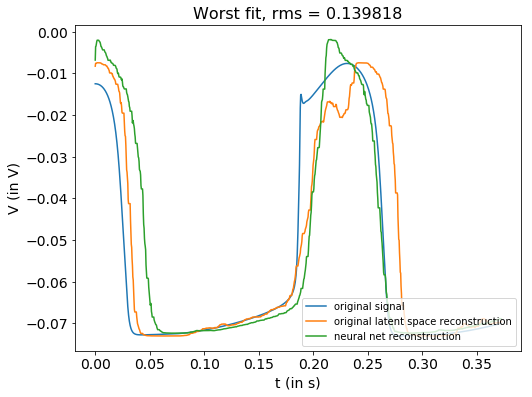

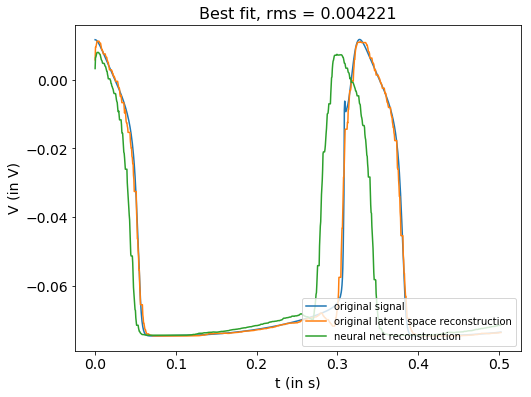

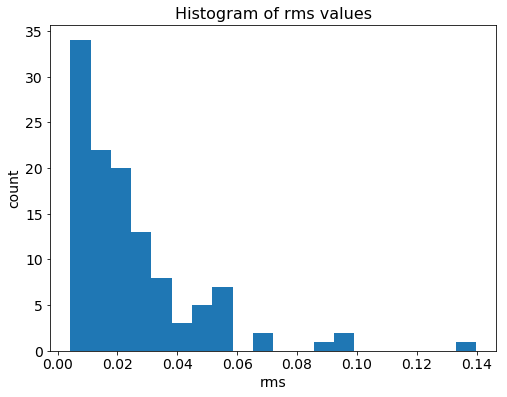

In [23]:
max_loc = test_rms.argmax()
min_loc = test_rms.argmin()

plt.figure()
plt.plot(test_t_small.iloc[max_loc], test_true.drop(to_drop, axis = 1).iloc[max_loc], label = 'original signal')
plt.plot(test_t_small.iloc[max_loc], test_originalLatent_rescaled.iloc[max_loc], label = 'original latent space reconstruction')
plt.plot(test_t_small.iloc[max_loc], test_prediction_rescaled.iloc[max_loc], label = 'neural net reconstruction')
plt.legend(loc = 'lower right', fontsize = 10)
plt.title('Worst fit, rms = %f' %test_rms.max(), fontsize = 16)
plt.xlabel('t (in s)', fontsize = 14)
plt.ylabel('V (in V)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.figure()
plt.plot(test_t_small.iloc[min_loc], test_true.drop(to_drop, axis = 1).iloc[min_loc], label = 'original signal')
plt.plot(test_t_small.iloc[min_loc], test_originalLatent_rescaled.iloc[min_loc], label = 'original latent space reconstruction')
plt.plot(test_t_small.iloc[min_loc], test_prediction_rescaled.iloc[min_loc], label = 'neural net reconstruction')
plt.legend(loc = 'lower right', fontsize = 10)
plt.title('Best fit, rms = %f' %test_rms.min(), fontsize = 16)
plt.xlabel('t (in s)', fontsize = 14)
plt.ylabel('V (in V)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.figure()
plt.hist(test_rms, bins = 20)
plt.title('Histogram of rms values', fontsize = 16)
plt.xlabel('rms', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [24]:
def compute_real_rms(y_true, y_pred):
    squares = (y_true - y_pred)**2
    return squares.sum(axis = 1) / y_true.shape[1]

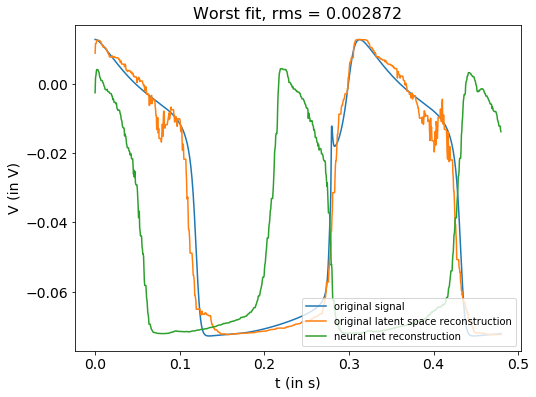

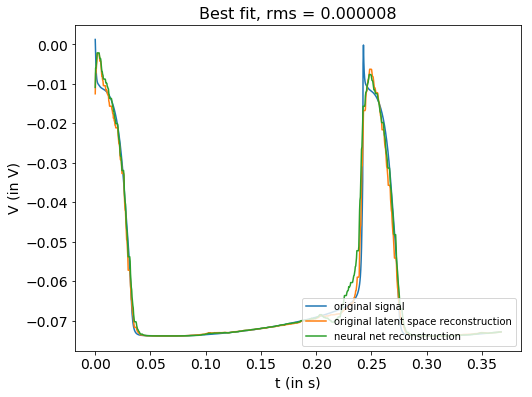

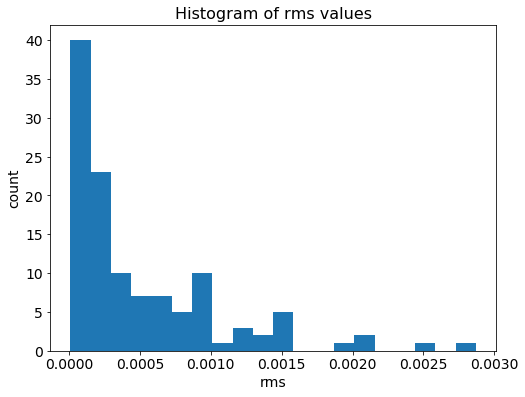

In [25]:
test_real_rms = compute_real_rms(test_true.drop(to_drop, axis = 1), test_prediction_rescaled)

real_max_loc = test_real_rms.idxmax()
real_min_loc = test_real_rms.idxmin()

plt.figure()
plt.plot(test_t_small.loc[real_max_loc], test_true.drop(to_drop, axis = 1).loc[real_max_loc], label = 'original signal')
plt.plot(test_t_small.loc[real_max_loc], test_originalLatent_rescaled.loc[real_max_loc], label = 'original latent space reconstruction')
plt.plot(test_t_small.loc[real_max_loc], test_prediction_rescaled.loc[real_max_loc], label = 'neural net reconstruction')
plt.legend(loc = 'lower right', fontsize = 10)
plt.title('Worst fit, rms = %f' %test_real_rms.max(), fontsize = 16)
plt.xlabel('t (in s)', fontsize = 14)
plt.ylabel('V (in V)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.figure()
plt.plot(test_t_small.loc[real_min_loc], test_true.drop(to_drop, axis = 1).loc[real_min_loc], label = 'original signal')
plt.plot(test_t_small.loc[real_min_loc], test_originalLatent_rescaled.loc[real_min_loc], label = 'original latent space reconstruction')
plt.plot(test_t_small.loc[real_min_loc], test_prediction_rescaled.loc[real_min_loc], label = 'neural net reconstruction')
plt.legend(loc = 'lower right', fontsize = 10)
plt.title('Best fit, rms = %f' %test_real_rms.min(), fontsize = 16)
plt.xlabel('t (in s)', fontsize = 14)
plt.ylabel('V (in V)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.figure()
plt.hist(test_real_rms, bins = 20)
plt.title('Histogram of rms values', fontsize = 16)
plt.xlabel('rms', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()